In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
data = pd.read_csv('data/aithon2020_level2_traning.csv')
data.head()

,emotion,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,...,pixel_2294,pixel_2295,pixel_2296,pixel_2297,pixel_2298,pixel_2299,pixel_2300,pixel_2301,pixel_2302,pixel_2303
0,Fear,231,212,156,164,174,138,161,173,182,...,104,138,152,122,114,101,97,88,110,152
1,Fear,55,55,55,55,55,54,60,68,54,...,90,83,77,53,37,34,30,34,30,57
2,Sad,20,17,19,21,25,38,42,42,46,...,29,36,68,91,85,93,97,99,107,118
3,Happy,4,2,13,41,56,62,67,87,95,...,59,66,80,74,69,99,28,3,7,12
4,Fear,255,255,255,255,255,255,255,255,255,...,94,21,22,51,71,80,82,79,79,83


In [3]:
only_pic = data.drop(['emotion'], axis=1)
only_pic.head()

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_2294,pixel_2295,pixel_2296,pixel_2297,pixel_2298,pixel_2299,pixel_2300,pixel_2301,pixel_2302,pixel_2303
0,231,212,156,164,174,138,161,173,182,200,...,104,138,152,122,114,101,97,88,110,152
1,55,55,55,55,55,54,60,68,54,85,...,90,83,77,53,37,34,30,34,30,57
2,20,17,19,21,25,38,42,42,46,54,...,29,36,68,91,85,93,97,99,107,118
3,4,2,13,41,56,62,67,87,95,62,...,59,66,80,74,69,99,28,3,7,12
4,255,255,255,255,255,255,255,255,255,255,...,94,21,22,51,71,80,82,79,79,83


In [4]:
only_pic.shape

(10817, 2304)

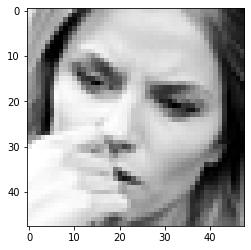

In [5]:
for pic in only_pic.iterrows():
    tmp = np.array(pic[1]).reshape((48,48))
    plt.imshow(tmp, cmap='gray')
    break

In [6]:
labels = data['emotion']
labels.shape

(10817,)

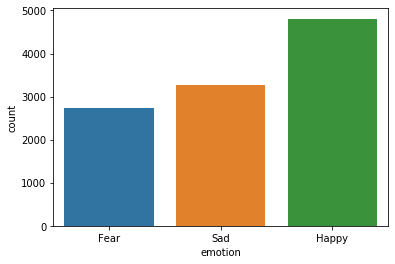

In [7]:
sns.countplot(labels)

In [8]:
from sklearn.model_selection import train_test_split
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import make_grid

#neural net imports
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [9]:
r_mapping = {0:'Fear', 1:'Happy', 2:'Sad'}
mapping = {'Fear':0, 'Happy':1,'Sad':2}
train_labels = data['emotion'].map(mapping).values
train_images = (data.iloc[:, 1:].values).astype('float32')

In [10]:
train_images.shape

(10817, 2304)

In [11]:
train_labels.shape

(10817,)

In [12]:
# reshape images
train_images = train_images.reshape(train_images.shape[0],1 , 48, 48)
train_images.shape

(10817, 1, 48, 48)

In [13]:
train_images, val_image, train_labels, val_labels = train_test_split(train_images, train_labels,
                                                                     test_size=0.20, random_state=42)

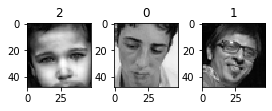

In [14]:
#Add some validation later
for i in range(10,13):
    plt.subplot(330 + (i+1))
    plt.imshow(train_images[i].squeeze(), cmap=plt.get_cmap('gray'))
    plt.title(train_labels[i])

In [15]:
#Convert numpy data into tensor for PyTorch
train_image_tensor = torch.tensor(train_images) / 255.0
train_labels_tensor = torch.tensor(train_labels)

val_image_tensor = torch.tensor(val_image) / 255.0
val_label_tensor = torch.tensor(val_labels)

val_tensor = TensorDataset(val_image_tensor, val_label_tensor)
train_tensor = TensorDataset(train_image_tensor, train_labels_tensor)

In [16]:
#DataLoader for train and test
train_loader = DataLoader(train_tensor, batch_size=16, num_workers=2, shuffle=True)
val_loader = DataLoader(val_tensor, batch_size=16, num_workers=2, shuffle=False)

In [23]:
#------------Now Modeling---------------
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=5)
        self.conv2_drop = nn.Dropout2d(p=0.2)
        self.conv2_bn = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 512, kernel_size=3)
        self.conv3_drop = nn.Dropout2d(p=0.2)
        self.conv3_bn = nn.BatchNorm2d(512)
        self.conv4 = nn.Conv2d(512, 128, kernel_size=3)
        self.conv4_drop = nn.Dropout2d(p=0.2)
        self.conv4_bn = nn.BatchNorm2d(20)
        self.fc1 = nn.Linear(4608, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 3)
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2_bn(self.conv2(x))), 2))
        x = F.relu(F.max_pool2d(self.conv3_drop(self.conv3_bn(self.conv3(x))), 2))
        #print(x.shape)
        #x = F.relu(F.max_pool2d(self.conv2_drop(self.conv4(x)), 2))
        #print(x.shape)
        x = x.view(-1, 4608)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training)
        x = self.fc3(x)
        return F.log_softmax(x)


model = Model()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if (device.type=='cuda'):
    model.cuda()

In [24]:
optimizer = optim.Adam(model.parameters(), lr=0.0005) #adam optimizer from optim module
model.train()

losses = []
for epoch in range(2):
    for batch_idx, (data, target) in enumerate(train_loader):
        # Get Samples
        if (device.type=='cuda'):
            data, target = Variable(data.cuda()), Variable(target.cuda())
        else:
            data, target = Variable(data), Variable(target) # making group of 16
            
        
        # Init
        optimizer.zero_grad() #making gradient zero for new mini-batch. 

        # Predict
        y_pred = model(data) 
         
        
        # Calculate loss
        loss = F.cross_entropy(y_pred, target)
        losses.append(loss.data)
        
        # Backpropagation
        loss.backward()  #It computes gradient of loss w.r.t all the parameters and store them in (parameter.grad) attribute.
        optimizer.step() #optimizer.step() updates all the parameters based on (parameter.grad)
        
        '''
        # model evaluation on validation data
        if (device.type=='cuda'):
            evaluate_x=val_image_tensor.cuda()
            evaluate_y=val_label_tensor.cuda()
        else:
            evaluate_x=val_image_tensor
            evaluate_y=val_label_tensor
            
        output = model(evaluate_x)
        pred = output.data.max(1)[1]
        d = pred.eq(evaluate_y.data).cpu()
        a=(d.sum().data.cpu().numpy())
        b=d.size()
        b=torch.tensor(b)
        b=(b.sum().data.cpu().numpy())
        val_accuracy = a/b
        
        #Train Accuracy
        if (device.type=='cuda'):
            evaluate_x=train_image_tensor.cuda()
            evaluate_y=train_labels_tensor.cuda()
        else:
            evaluate_x=train_image_tensor
            evaluate_y=train_labels_tensor
            
        output = model(evaluate_x)
        pred = output.data.max(1)[1]
        d = pred.eq(evaluate_y.data).cpu()
        a=(d.sum().data.cpu().numpy())
        b=d.size()
        b=torch.tensor(b)
        b=(b.sum().data.cpu().numpy())
        train_accuracy = a/b
        '
        
        # Display
        #if batch_idx % 100 == 1:
        print('\r Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tTrain_Acc: {:.6f}\tVal_Acc: {:.6f}'.format( epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data, train_accuracy, val_accuracy), end='')
        '''
        print('\r {:.6f}'.format(loss.data), end='')
    print()

C:\Users\Vicky\anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


 1.200182
 1.119463


In [ ]:
#Train Accuracy
 if (device.type=='cuda'):
    evaluate_x=train_image_tensor.cuda()
    evaluate_y=train_labels_tensor.cuda()
else:
    evaluate_x=train_image_tensor
    evaluate_y=train_labels_tensor
output = model(evaluate_x)
pred = output.data.max(1)[1]
d = pred.eq(evaluate_y.data).cpu()
a=(d.sum().data.cpu().numpy())
b=d.size()
b=torch.tensor(b)
b=(b.sum().data.cpu().numpy())
train_accuracy = a/b
